In [1]:
# Python code for:
# Alexander Heyde, David Rohde, Cameron S. McAlpine, Shuang Zhang, Friedrich F. Hoyer, Jeffrey M. Gerold, David Cheek, Yoshiko Iwamoto, Maximilian J. Schloss, Katrien Vandoorne, Oriol Iborra - Egea, Christian Muñoz - Guijosa, Antoni Bayes - Genis, Johannes G. Reiter, Morgan Craig, Filip K. Swirski, Matthias Nahrendorf, Martin A. Nowak, Kamila Naxerova. 
# Increased stem cell proliferation in atherosclerosis accelerates clonal hematopoiesis.

In [2]:
import numpy as np                    # mathematics
import kingman                        # coalescence
import seaborn as sns                 # visualization
from matplotlib import pyplot as plt  # plotting
%matplotlib inline

In [3]:
# Table S2
# All time measurements in years
b = 365/28     # Average baseline HSC proliferation rate
age = 40       # Age of onset for elevated HSC proliferation rate
T = 70         # Age at sequencing
thresh1 = .02  # Detection frequency (baseline)
thresh2 = .08  # Detection frequency (alternative)
pop = 100000   # Number of HSCs
mutrate = 1.5  # Mean number of neutral mutations acquired by each daughter cell per division

M = 10         # Number of independent realizations
body = 10**13  # Number of cells in the body after development
progen = 100   # Number of HSC progenitor cells
u = 50         # Possible mutational realizations before birth
U = 50         # Possible mutational realizations after birth

In [4]:
%%time
# Control cohort: neutral VAF simulations

# Set distribution of proliferation rates for control cohort
R = np.array([0.4883, 1.8066, 0.9861, 0.9861, 0.9151, 1.0966, 0.2832, 0.6453, 1.9959, 0.7968]) # from Fig 2C
lifes = (min(T,age)+max(0,T-age)*R)*b
x = np.array([])
weightx = np.array([])

# Simulate mutation and cell division in control patients
nx0 = [0]*M
nx1 = [0]*M
nx2 = [0]*M
for m in range(M):
    print(M-m)
    
    #Simulate cell division backwards in time via coalescent
    #np.random.seed(m)
    life = np.random.choice(lifes)
    outp = kingman.simulate(pop,m)
    parents = outp[0]
    times = np.array(outp[1])*2*pop
    times[0] = 0
    finalStage = life+np.log(pop/progen)+np.log(1+times*body/pop-life-np.log(pop/progen))
    times = np.where(times < life, times, np.where(times < life+pop/progen-1, life+np.log(1+times-life), finalStage))
    nodes = len(times)

    #Determine coalescent tree structure and identify mutations
    branch = [0]*nodes
    branchearly = [0]*nodes
    for n in range(1,nodes):
        branch[n] = np.maximum(0,np.minimum(times[parents[n]],life)-times[n])
        branchearly[n] = np.maximum(0,times[parents[n]]-np.maximum(times[n],life))
    branch[nodes-1] = 0
    branchearly[nodes-1] = max(0,np.log(pop/progen*body)+life-times[nodes-1])
    #np.random.seed(m+M)
    muts = np.random.poisson(np.array(branch)*U+np.array(branchearly)*u)

    #Trace mutations down ancestry to calculate variant frequency
    cells = [0]*nodes
    for n in [i for i in range(len(times)) if times[i] == 0]:
        while n > -1:
            cells[n] = cells[n]+1
            n = parents[n]
    freq = np.array(cells)/pop
    
    #Count mutations that exceed a VAF threshold of 0, thresh1, or thresh2
    x = np.concatenate([x, freq])
    weightx = np.concatenate([weightx, muts])
    nx0[m] = np.dot(freq>0, muts)
    nx1[m] = np.dot(freq>thresh1, muts)
    nx2[m] = np.dot(freq>thresh2, muts)
print(x)

10


9
8
7
6
5
4
3
2
1
[  1.00001000e+00   1.00000000e-05   1.00000000e-05 ...,   6.68750000e-01
   3.31250000e-01   1.00000000e+00]
Wall time: 20min 59s


In [5]:
%%time
# Disease cohort: neutral VAF simulations

# Set distribution of proliferation rates for disease cohort
R = np.array([1.9328, 2.2878, 1.6961, 3.8025, 1.4595, 3.3843, 1.7908, 3.7393, 1.9170, 2.8637]) # from Fig 2C
lifes = (min(T,age)+max(0,T-age)*R)*b
y = np.array([])
weighty = np.array([])

# Simulate mutation and cell division in disease patients
ny0 = [0]*M
ny1 = [0]*M
ny2 = [0]*M
for m in range(M):
    print(M-m)
    
    #Simulate cell division backwards in time via coalescent
    #np.random.seed(m)
    life = np.random.choice(lifes)
    outp = kingman.simulate(pop,m)
    parents = outp[0]
    times = np.array(outp[1])*2*pop
    times[0] = 0
    finalStage = life+np.log(pop/progen)+np.log(1+times*body/pop-life-np.log(pop/progen))
    times = np.where(times < life, times, np.where(times < life+pop/progen-1, life+np.log(1+times-life), finalStage))
    nodes = len(times)

    #Determine coalescent tree structure and identify mutations
    branch = [0]*nodes
    branchearly = [0]*nodes
    for n in range(1,nodes):
        branch[n] = np.maximum(0,np.minimum(times[parents[n]],life)-times[n])
        branchearly[n] = np.maximum(0,times[parents[n]]-np.maximum(times[n],life))
    branch[nodes-1] = 0
    branchearly[nodes-1] = max(0,np.log(pop/progen*body)+life-times[nodes-1])
    np.random.seed(m+M)
    muts = np.random.poisson(np.array(branch)*U+np.array(branchearly)*u)

    #Trace mutations down ancestry to calculate variant frequency
    cells = [0]*nodes
    for n in [i for i in range(len(times)) if times[i] == 0]:
        while n > -1:
            cells[n] = cells[n]+1
            n = parents[n]
    freq = np.array(cells)/pop
    
    #Count mutations that exceed a VAF threshold of 0, thresh1, or thresh2
    y = np.concatenate([y, freq])
    weighty = np.concatenate([weighty, muts])    
    ny0[m] = np.dot(freq>0, muts)
    ny1[m] = np.dot(freq>thresh1, muts)
    ny2[m] = np.dot(freq>thresh2, muts)
print(y)

10


9
8
7
6
5
4
3
2
1
[  1.00001000e+00   1.00000000e-05   1.00000000e-05 ...,   6.68750000e-01
   3.31250000e-01   1.00000000e+00]
Wall time: 22min 11s


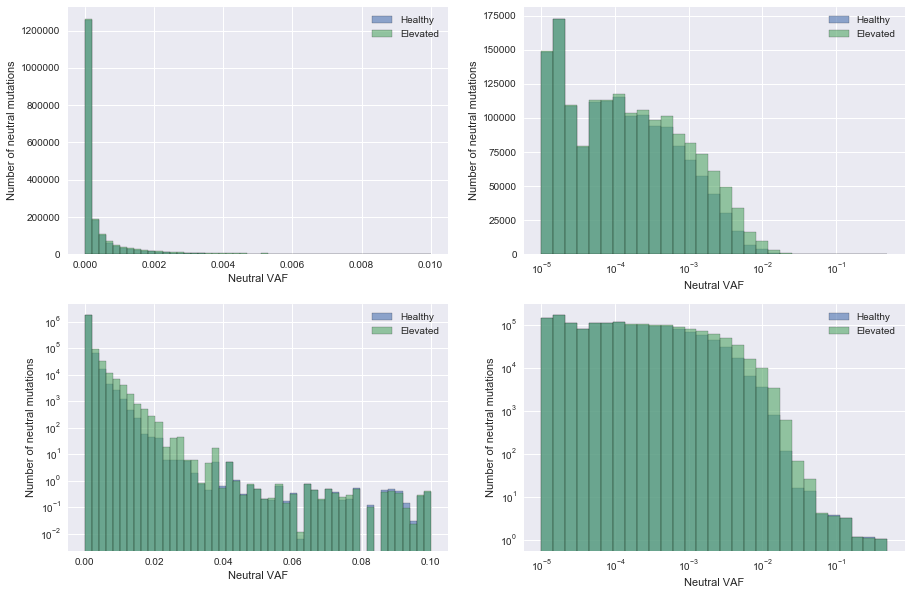

In [6]:
# Plot VAF spectrum (fn various axis scalings

fig, axs = plt.subplots(2,2, figsize=(15,10))

# Linear-linear
binx = np.linspace(0, .01, 50)
axs[0,0].hist(x/2, edgecolor='black', bins=binx, weights=weightx/(M*u/mutrate), log=False, alpha=.6)
axs[0,0].hist(y/2, edgecolor='black', bins=binx, weights=weighty/(M*u/mutrate), log=False, alpha=.6)
sns.despine()
axs[0,0].set_xlabel("Neutral VAF")
axs[0,0].set_ylabel("Number of neutral mutations")
axs[0,0].legend(['Healthy','Elevated'])

# Log-linear
binx = np.power(10,np.linspace(-np.log10(pop), np.log10(.5), 30))
xhist = axs[0,1].hist(x/2, edgecolor='black', bins=binx, weights=weightx/(M*u/mutrate), log=False, alpha=.6)
yhist = axs[0,1].hist(y/2, edgecolor='black', bins=binx, weights=weighty/(M*u/mutrate), log=False, alpha=.6)
sns.despine()
axs[0,1].set_xscale('log')
axs[0,1].set_xlabel("Neutral VAF")
axs[0,1].set_ylabel("Number of neutral mutations")
axs[0,1].legend(['Healthy','Elevated'])

# Linear-Log
binx = np.linspace(0, .1, 50)
axs[1,0].hist(x/2, edgecolor='black', bins=binx, weights=weightx/(M*u/mutrate), log=True, alpha=.6)
axs[1,0].hist(y/2, edgecolor='black', bins=binx, weights=weighty/(M*u/mutrate), log=True, alpha=.6)
sns.despine()
axs[1,0].set_xlabel("Neutral VAF")
axs[1,0].set_ylabel("Number of neutral mutations")
axs[1,0].legend(['Healthy','Elevated'])

# Log-Log
binx = np.power(10,np.linspace(-np.log10(pop), np.log10(.5), 30))
axs[1,1].hist(x/2, edgecolor='black', bins=binx, weights=weightx/(M*u/mutrate), log=True, alpha=.6)
axs[1,1].hist(y/2, edgecolor='black', bins=binx, weights=weighty/(M*u/mutrate), log=True, alpha=.6)
sns.despine()
axs[1,1].set_xscale('log')
axs[1,1].set_xlabel("Neutral VAF")
axs[1,1].set_ylabel("Number of neutral mutations")
axs[1,1].legend(['Healthy','Elevated'])

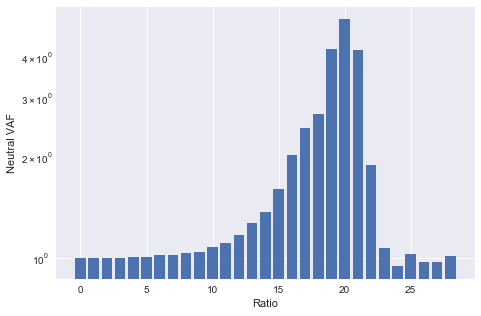

In [7]:
# Plot ratio of neutral variants between disease and control cohorts (Figure 4, bottom row)
yx_ratio = yhist[0] / xhist[0]
fig, ax = plt.subplots(figsize=(7.5,5))
ax.bar(range(len(yx_ratio)), yx_ratio)
sns.despine()
ax.set_xlabel("Ratio")
ax.set_ylabel("Neutral VAF")
ax.set_yscale("log")